In [60]:
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt

In [87]:
import re
from typing import TypedDict


class LogEntry(TypedDict):
    round: int
    mean_reward: float
    win_rate: float
    elapsed: float


def parse_log(fn: Path) -> list[LogEntry]:
    pattern = (
        r"Round (\d+): mean_reward=([-\d.]+), win_rate=([\d.]+), elapsed=([\d.]+)s"
    )
    entries = []

    with open(fn) as f:
        for line in f:
            if match := re.search(pattern, line):
                entries.append(
                    LogEntry(
                        round=int(match.group(1)),
                        mean_reward=float(match.group(2)),
                        win_rate=float(match.group(3)),
                        elapsed=float(match.group(4)),
                    )
                )

    df = pd.DataFrame(entries)
    df.set_index("round", inplace=True)

    return df


In [88]:
fns = list(Path("../../outdirs/0520").glob("run_*/train.log"))

dfs = {x.parent.name: parse_log(x) for x in fns}
df = pd.concat(dfs.values(), keys=dfs.keys(), names=["run"])

df = df.query("run in ['run_30', 'run_32', 'run_33', 'run_34', 'run_35']").copy()

rollouts_per_round = {
    "run_30": 65536,
    "run_32": 8192,
    "run_33": 16384,
    "run_34": 32768,
    "run_35": 32768.1,
}
df["rollouts_per_round"] = df.index.get_level_values("run").map(rollouts_per_round)
df["rollouts"] = df.index.get_level_values("round") * df["rollouts_per_round"]

In [92]:
df.query("run == 'run_34' and round == 30")

,,mean_reward,win_rate,elapsed,rollouts_per_round,rollouts
run,round,,,,,
run_34,30,0.41,0.577,138.432,32768.0,983040.0


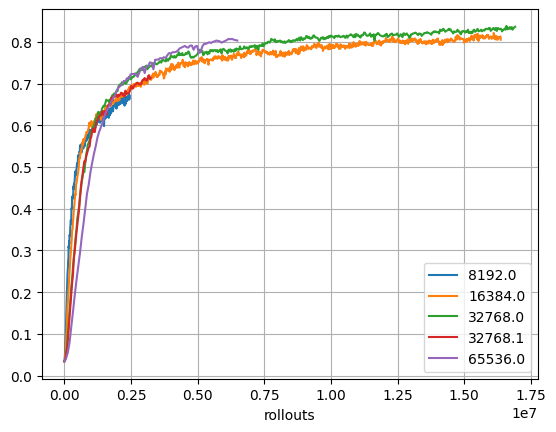

In [89]:
ax = plt.gca()
for rollouts_per_round, sub_df in df.groupby("rollouts_per_round"):
    sub_df.plot(
        x="rollouts",
        y="win_rate",
        label=rollouts_per_round,
        legend=True,
        ax=ax,
        grid=True,
    )